# Objective
* identify which variables have strong correlation to 'Q35'
* this will be another method of identifying key drivers of resident satisfaction


# Import Necessary Libraries

In [1]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Loading and Reading File



In [2]:
from google.colab import files # Googles way of importing files
uploaded = files.upload()

Saving 2023 Renter Survey Data.csv to 2023 Renter Survey Data.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['2023 Renter Survey Data.csv']))

# Basic EDA before conducting correlation analysis

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df.head()

,Region,Q1,Q2,Q3,Q4,Q5,Q6:1,Q6:2,Q6:3,Q6:4,Q6:5,Q6:6,Q7:1,Q7:2,Q7:3,Q7:4,Q7:5,Q7:6,Q8,Q9,Q9a,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q16a,Q16b,Q16c,Q16d,Q17,Q18,Q19,Q20:1,Q20:2,Q20:3,Q20:4,Q21,Q21a,Q21b,Q21c,Q21d,Q21e,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q28a,Q28b,Q28c,Q28d,Q29,Q29a,Q29b,Q29c,Q29d,Q29e,Q29f,Q29g,Q29h,Q29i,Q29j,Q29k,Q30,Q31,Q32:1,Q32:2,Q32:3,Q32:4,Q32:5,Q32:6,Q32:7,Q32:8,Q33:1,Q33:2,Q33:3,Q33:4,Q33:5,Q33:6,Q34,Q35,Q36,PosNeg,ServiceArea
0,Region,How long have you been a resident at HousingFirst?,Which language do you speak the most at home?,How would you describe your background?,How old are you?,Have you made contact with HousingFirst in the last 12 months?,What was the reason that you contacted HousingFirst?,What was the reason that you contacted HousingFirst?,What was the reason that you contacted HousingFirst?,What was the reason that you contacted HousingFirst?,What was the reason that you contacted HousingFirst?,What was the reason that you contacted HousingFirst?,How did you last contact HousingFirst?,How did you last contact HousingFirst?,How did you last contact HousingFirst?,How did you last contact HousingFirst?,How did you last contact HousingFirst?,How did you last contact HousingFirst?,Was your enquiry answered within a reasonable time?,The ability of staff to deal with your query quickly and efficiently,The final outcome of your query,"Overall, how satisfied or dissatisfied are you with communication with HousingFirst?",Do you know what your rights are as a resident of HousingFirst?,How satisfied or dissatisfied are you that your rights as a resident are upheld by HousingFirst?,How satisfied or dissatisfied are you that HousingFirst treats you fairly?,Do you know how to make a complaint to HousingFirst?,Have you made a complaint to HousingFirst in the last 12 months?,How easy it was to make your complaint,The information and advice provided by staff,How well you were kept informed about the progress of your complaint,The speed with which your complaint was dealt with,The outcome of your complaint,"Overall, how satisfied or dissatisfied are you about how your complaint was dealt with?","Overall, how satisfied or dissatisfied are you with the condition of your home?",Have you reported a repair to HousingFirst in the last 12 months?,How did you request the repair?,How did you request the repair?,How did you request the repair?,How did you request the repair?,My call was answered in a timely manner or my phone message was returned promptly,HousingFirst staff were helpful and attentive,I was advised of how long the works would take and was kept informed of progress,The contractor called me to make an appointment,The contractor attended at the arranged time,The contractor was respectful and courteous towards me and my property,Overall how satisfied are you with the quality of the repair carried out at your home?,Have you used HousingFirst’ out-of-hours emergency repairs service in the last 12 months?,How satisfied or dissatisfied were you with the out-of-hours emergency repairs service?,"Generally, how satisfied or dissatisfied are you with the way we deal with repairs and maintenance?",How satisfied or dissatisfied are you with the location of your home?,How satisfied or dissatisfied are you with your neighbourhood as a place to live?,"Suitability of your home to your circumstances e.g. your mobility, other needs",Safety of your home,"Services available in your area (e.g. schools, doctors)",Transport available in your area,Size of your home,Car parking,Rubbish or litter,Noisy neighbours,Problems with pets and animals,Racial or other harassment,Drunk or rowdy behaviour,Vandalism and graffiti,People damaging your property,Drug use or dealing,Theft,Abandoned or burnt vehicles,Family violence or physical assault,Are you aware of opportunities to participate in HousingFirst's resident advisory groups such as PAINT?,Are you aware of how you can influence / suggest resident activities in your area?,Are there any barriers or conc

In [5]:
# getting a grasp on the df we're working with
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 89 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Region       638 non-null    object
 1   Q1           623 non-null    object
 2   Q2           622 non-null    object
 3   Q3           620 non-null    object
 4   Q4           621 non-null    object
 5   Q5           621 non-null    object
 6   Q6:1         374 non-null    object
 7   Q6:2         90 non-null     object
 8   Q6:3         155 non-null    object
 9   Q6:4         54 non-null     object
 10  Q6:5         16 non-null     object
 11  Q6:6         93 non-null     object
 12  Q7:1         395 non-null    object
 13  Q7:2         101 non-null    object
 14  Q7:3         10 non-null     object
 15  Q7:4         187 non-null    object
 16  Q7:5         21 non-null     object
 17  Q7:6         10 non-null     object
 18  Q8           523 non-null    object
 19  Q9           502 non-null    

# Data Pre-Processing

For satisfaction questions (e.g., Q9, Q10, Q12, Q13, Q16, Q16a, etc.), I'll use the scale:
* "Very satisfied" = 5
* "Fairly satisfied" = 4
* "Neither satisfied nor dissatisfied" = 3
* "Fairly dissatisfied" = 2
* "Very dissatisfied" = 1
* "No opinion" = NaN (we'll treat these as missing values for the purpose of correlation analysis)

For binary or categorical responses (e.g., Q8, Q11, Q14), we'll use specific mappings.
* For example:"Yes" = 1, "No" = 0, "Unsure" = NaN


In [6]:
# Preserving question descriptions for future use and excluding it from analysis

# Preserve the question descriptions
question_descriptions = df.iloc[0, :].to_frame().T

# Remove the row with question descriptions from the dataset
df1 = df.drop(index=0)

  # df1 is new dataframe without question descriptions

In [7]:
# Define the mapping for satisfaction levels
satisfaction_mapping = {
    "Very satisfied": 5,
    "Fairly satisfied": 4,
    "Neither satisfied nor dissatisfied": 3,
    "Fairly dissatisfied": 2,
    "Very dissatisfied": 1,
    "No opinion": None  # Treat as NaN
}

# List of satisfaction questions to apply the mapping
satisfaction_questions = ['Q9', 'Q10', 'Q12', 'Q13', 'Q16', 'Q16a', 'Q16b', 'Q16c', 'Q16d', 'Q17', 'Q18', 'Q21', 'Q21a', 'Q21b', 'Q21c', 'Q21d', 'Q21e', 'Q22', 'Q24']

# Apply the mapping to satisfaction questions in df1
for question in satisfaction_questions:
    df1[question] = df1[question].map(satisfaction_mapping)

# Convert Q35 as well using the defined satisfaction mapping in df1
df1['Q35'] = df1['Q35'].map(satisfaction_mapping)


In [8]:
# Example mappings for binary/categorical responses
binary_categorical_mapping = {
    'Q8': {"Yes": 1, "No": 0, "Unsure": None},  # Example mapping for Q8
    'Q11': {"Yes": 1, "No": 0, "Unsure": None},  # Example mapping for Q11
    'Q14': {"Yes": 1, "No": 0, "Unsure": None},  # Example mapping for Q14
    # Add more questions and mappings as needed
}

# Apply the mappings to binary/categorical questions in df1
for question, mapping in binary_categorical_mapping.items():
    df1[question] = df1[question].map(mapping)


# Running the Correlation Analysis
* Reasoning: to identify how different variables correlate with Q35, which reflects the overall satisfaction with the services provided. This analysis will help us understand which factors are most closely associated with resident satisfaction.

In [10]:
# Calculate the Pearson correlation coefficients between Q35 and other questions
correlation_matrix = df1[satisfaction_questions + ['Q35']].corr()

# Extract the correlation values with Q35, excluding Q35's correlation with itself
  # sorting in decending order to easily identify strongest correlations
correlation_with_q35 = correlation_matrix['Q35'].drop('Q35').sort_values(ascending=False)

correlation_with_q35


Q12     0.766459
Q13     0.714453
Q10     0.705310
Q9      0.699161
Q21a    0.694949
Q16c    0.663975
Q21b    0.638103
Q16b    0.627636
Q16a    0.627563
Q18     0.627021
Q17     0.626120
Q16d    0.621008
Q21     0.601388
Q24     0.573745
Q16     0.559796
Q21c    0.548060
Q22     0.526665
Q21d    0.517072
Q21e    0.511843
Name: Q35, dtype: float64

# Visualizing the top 10 variables that correlate with question 35

<ipython-input-11-f79f245ebdb5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_correlations.values, y=top_10_correlations.index, palette="coolwarm")


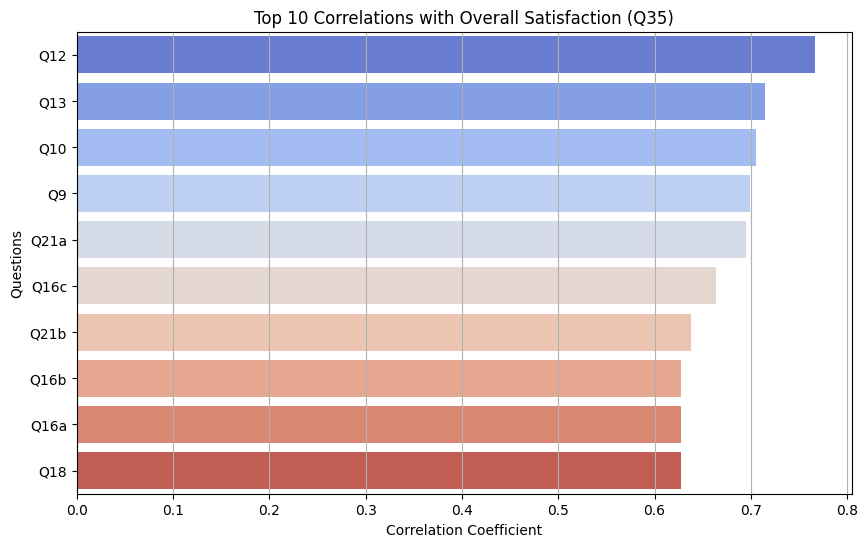

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

top_10_correlations = correlation_with_q35.head(10)

# Visualize the top 10 correlations with Q35
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_correlations.values, y=top_10_correlations.index, palette="coolwarm")
plt.title('Top 10 Correlations with Overall Satisfaction (Q35)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Questions')
plt.grid(axis='x')

plt.show()


In [14]:
# want to find the row index of each question so I can easily display the most correlated question descriptions

# Dictionary to store column names and their index locations
column_index_locations = {}

# Iterate through each column name in 'question_descriptions' and find its index location
for column in question_descriptions_columns:
    index_position = question_descriptions.columns.get_loc(column)
    column_index_locations[column] = index_position

# Print the column index locations
column_index_locations


{'Region': 0,
 'Q1': 1,
 'Q2': 2,
 'Q3': 3,
 'Q4': 4,
 'Q5': 5,
 'Q6:1': 6,
 'Q6:2': 7,
 'Q6:3': 8,
 'Q6:4': 9,
 'Q6:5': 10,
 'Q6:6': 11,
 'Q7:1': 12,
 'Q7:2': 13,
 'Q7:3': 14,
 'Q7:4': 15,
 'Q7:5': 16,
 'Q7:6': 17,
 'Q8': 18,
 'Q9': 19,
 'Q9a': 20,
 'Q10': 21,
 'Q11': 22,
 'Q12': 23,
 'Q13': 24,
 'Q14': 25,
 'Q15': 26,
 'Q16': 27,
 'Q16a': 28,
 'Q16b': 29,
 'Q16c': 30,
 'Q16d': 31,
 'Q17': 32,
 'Q18': 33,
 'Q19': 34,
 'Q20:1': 35,
 'Q20:2': 36,
 'Q20:3': 37,
 'Q20:4': 38,
 'Q21': 39,
 'Q21a': 40,
 'Q21b': 41,
 'Q21c': 42,
 'Q21d': 43,
 'Q21e': 44,
 'Q22': 45,
 'Q23': 46,
 'Q24': 47,
 'Q25': 48,
 'Q26': 49,
 'Q27': 50,
 'Q28': 51,
 'Q28a': 52,
 'Q28b': 53,
 'Q28c': 54,
 'Q28d': 55,
 'Q29': 56,
 'Q29a': 57,
 'Q29b': 58,
 'Q29c': 59,
 'Q29d': 60,
 'Q29e': 61,
 'Q29f': 62,
 'Q29g': 63,
 'Q29h': 64,
 'Q29i': 65,
 'Q29j': 66,
 'Q29k': 67,
 'Q30': 68,
 'Q31': 69,
 'Q32:1': 70,
 'Q32:2': 71,
 'Q32:3': 72,
 'Q32:4': 73,
 'Q32:5': 74,
 'Q32:6': 75,
 'Q32:7': 76,
 'Q32:8': 77,
 'Q33:1': 78,
 'Q3

In [16]:
# top 10 correlation question descriptions (Q12 is the highest)

question_descriptions.iloc[0,[23,24,21,19,40,30,41,29,28,33]]

Q12     How satisfied or dissatisfied are you that your rights as a resident are upheld by HousingFirst?
Q13                           How satisfied or dissatisfied are you that HousingFirst treats you fairly?
Q10                 Overall, how satisfied or dissatisfied are you with communication with HousingFirst?
Q9                                  The ability of staff to deal with your query quickly and efficiently
Q21a                                                       HousingFirst staff were helpful and attentive
Q16c                                                  The speed with which your complaint was dealt with
Q21b                    I was advised of how long the works would take and was kept informed of progress
Q16b                                How well you were kept informed about the progress of your complaint
Q16a                                                        The information and advice provided by staff
Q18                      Overall, how satisfied or diss

In [17]:
# presenting question descriptions in a table
selected_descriptions = question_descriptions.iloc[0, [23, 24, 21, 19, 40, 30, 41, 29, 28, 33]]

# Convert the series to a DataFrame for a cleaner display, setting the question numbers as the index
description_table = selected_descriptions.to_frame().reset_index()
description_table.columns = ['Question', 'Description']

# Display the table
description_table


,Question,Description
0,Q12,How satisfied or dissatisfied are you that your rights as a resident are upheld by HousingFirst?
1,Q13,How satisfied or dissatisfied are you that HousingFirst treats you fairly?
2,Q10,"Overall, how satisfied or dissatisfied are you with communication with HousingFirst?"
3,Q9,The ability of staff to deal with your query quickly and efficiently
4,Q21a,HousingFirst staff were helpful and attentive
5,Q16c,The speed with which your complaint was dealt with
6,Q21b,I was advised of how long the works would take and was kept informed of progress
7,Q16b,How well you were kept informed about the progress of your complaint
8,Q16a,The information and advice provided by staff
9,Q18,"Overall, how satisfied or dissatisfied are you with the condition of your home?"


No charts were generated by quickchart
